# Basic Data Exploration 

In [21]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import plotly.graph_objects as go
import numpy as np
import torch 
from torch.nn import functional as F

### Basic utility functions 

In [22]:
def load_npy(file_path):
    """Load a .npy file and return its content."""
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    data = np.load(file_path, allow_pickle=True)
    return data


def load_rgb_image(image_path):
    """Load an RGB image from a file path."""
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"The image file {image_path} does not exist.")
    
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image file {image_path}.")
    
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 

def plot_mask_on_image(image, masks):
    """
    Plot masks on an image with red contours, slightly dimmed inside, and display the mask number.
    
    Args:
        image (np.ndarray): The RGB image on which to plot the masks.
        masks (np.ndarray): The masks to be plotted.
    """
    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)
    
    for i, mask in enumerate(masks):
        if mask.ndim == 2:  # Check if mask is 2D
            # Create a dimmed version of the image inside the mask
            dimmed_image = image.copy()
            dimmed_image[mask] = (dimmed_image[mask] * 0.5).astype(np.uint8)
            ax.imshow(dimmed_image, alpha=0.9)
            
            # Find contours of the mask
            contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            for contour in contours:
                ax.add_patch(patches.Polygon(contour.squeeze(), edgecolor='red', fill=False, linewidth=2))
            
            # Calculate the center of the mask to display the mask number
            y, x = np.where(mask)
            if len(x) > 0 and len(y) > 0:
                center_x, center_y = int(np.mean(x)), int(np.mean(y))
                ax.text(center_x, center_y, str(i + 1), color='red', fontsize=12, ha='center', va='center')
    
    plt.axis('off')
    plt.show()


def visualize(points=None, bboxes=None, downsample_factor=5, bboxes_color='red', fig: go.Figure = None, show: bool = True, enumerate_bboxes: bool = False, enumerate_corners: bool = False,
              bbox_format='orig') -> go.Figure:
    """
    Visualize point cloud and/or bounding boxes.

    Args:
        points (np.ndarray): Point cloud of shape (3, H, W). Coordinates in meters.
        bboxes (np.ndarray): Bounding boxes of shape (B, 8, 3), where B = number of boxes,
                             and 8 are corner points (x, y, z).
        downsample_factor (int): Downsampling factor for point cloud.
        enumerate_bboxes (bool): Whether to enumerate and label each bounding box.
        enumerate_corners (bool): Whether to enumerate and label each corner of every bounding box.
    """
    if fig is not None:
        fig = fig
    else:
        fig = go.Figure()

    # --------- Visualize point cloud ----------
    if points is not None:
        points_down = points[:, ::downsample_factor, ::downsample_factor]
        points_reshaped = points_down.reshape(3, -1)
        mask = ~np.all(points_reshaped == 0, axis=0)
        points_filtered = points_reshaped[:, mask]

        fig.add_trace(go.Scatter3d(
            x=points_filtered[0],
            y=points_filtered[1],
            z=points_filtered[2],
            mode='markers',
            marker=dict(
                size=2,
                color=points_filtered[2],
                colorscale='Viridis',
                opacity=0.8
            ),
            name='Point Cloud'
        ))

    # --------- Visualize bounding boxes ----------
    if bboxes is not None:
        def get_bbox_lines(corners):
            # Define the 12 edges of the bbox (by index into the 8 corners)
            if bbox_format == 'orig':
                edges = [
                    (0, 1), (1, 2), (2, 3), (3, 0),  # bottom face
                    (4, 5), (5, 6), (6, 7), (7, 4),  # top face
                    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
                ]
            elif bbox_format == 'trimesh':
                edges = [
                    (0, 1), (1, 3), (3, 2), (2, 0),  # bottom face (z = min)
                    (4, 5), (5, 7), (7, 6), (6, 4),  # top face (z = max)
                    (0, 4), (1, 5), (2, 6), (3, 7)   # vertical edges
                ]
            else: 
                raise ValueError("Unsupported bbox_format. Use 'orig' or 'trimesh'.")
            lines = []
            for start, end in edges:
                x = [corners[start, 0], corners[end, 0], None]
                y = [corners[start, 1], corners[end, 1], None]
                z = [corners[start, 2], corners[end, 2], None]
                lines.extend(zip(x, y, z))
            return list(zip(*lines))  # returns (xs, ys, zs)

        for i, bbox in enumerate(bboxes):
            xs, ys, zs = get_bbox_lines(bbox)
            fig.add_trace(go.Scatter3d(
                x=xs,
                y=ys,
                z=zs,
                mode='lines',
                line=dict(color=bboxes_color, width=4),
                name=f'BBox {i}'
            ))

            # Optionally enumerate bounding boxes
            if enumerate_bboxes:
                center = bbox.mean(axis=0)
                fig.add_trace(go.Scatter3d(
                    x=[center[0]],
                    y=[center[1]],
                    z=[center[2]],
                    mode='text',
                    text=[f'BBox {i}'],
                    textposition='top center',
                    name=f'BBox Label {i}'
                ))

            # Optionally enumerate corners
            if enumerate_corners:
                for j, corner in enumerate(bbox):
                    fig.add_trace(go.Scatter3d(
                        x=[corner[0]],
                        y=[corner[1]],
                        z=[corner[2]],
                        mode='text',
                        text=[f'C{j}'],
                        textposition='top center',
                        name=f'Corner {j}'
                    ))

    # --------- Layout ----------
    fig.update_layout(
        scene=dict(
            aspectmode='data',
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
        ),
        width=800,
        height=800,
        margin=dict(l=0, r=0, t=0, b=0)
    )

    if show:
        fig.show()
    return fig

### Visualize single sample

In [ ]:
#id = "8b061a8a-9915-11ee-9103-bbb8eae05561"
id = "8b061a8c-9915-11ee-9103-bbb8eae05561"

path_bbox = f"/home/hao1rng/sec_proj/dl_challenge/{id}/bbox3d.npy"
path_mask = f"/home/hao1rng/sec_proj/dl_challenge/{id}/mask.npy"
path_pc   = f"/home/hao1rng/sec_proj/dl_challenge/{id}/pc.npy"
path_rgb = f"/home/hao1rng/sec_proj/dl_challenge/{id}/rgb.jpg"

bbox3d = load_npy(path_bbox)
mask3d = load_npy(path_mask)
pc3d   = load_npy(path_pc)
rgb_image = load_rgb_image(path_rgb)

In [31]:
print(f"bbox3d shape: {bbox3d.shape}")
print(f"mask3d shape: {mask3d.shape}")
print(f"pc3d shape: {pc3d.shape}")
print(f"rgb_image shape: {rgb_image.shape}")

bbox3d shape: (8, 8, 3)
mask3d shape: (8, 423, 510)
pc3d shape: (3, 423, 510)
rgb_image shape: (423, 510, 3)


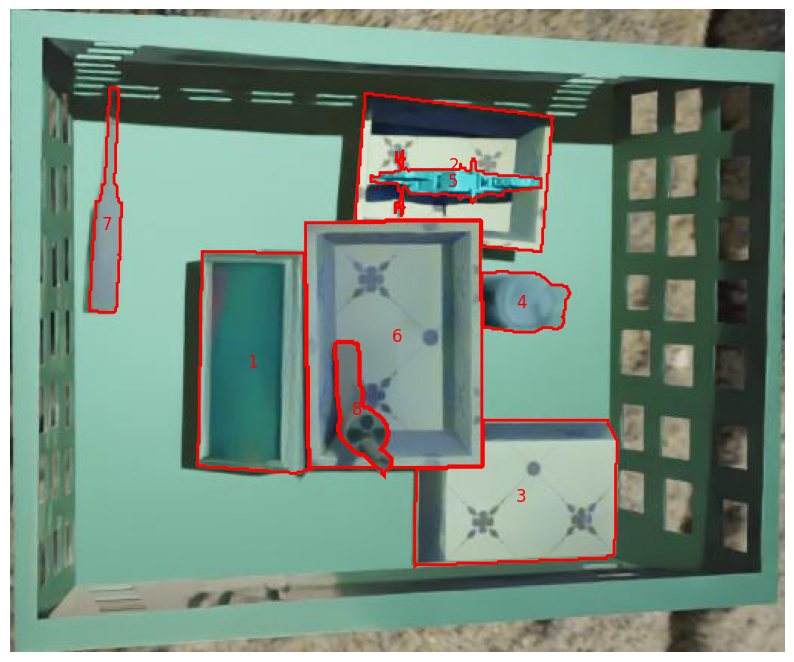

In [32]:
# Plot mask on image
plot_mask_on_image(rgb_image, mask3d)

In [33]:
# Example usage
visualize(points=pc3d, bboxes=bbox3d, downsample_factor=7, enumerate_bboxes=True, enumerate_corners=True)
print("Visualization complete.")

Visualization complete.


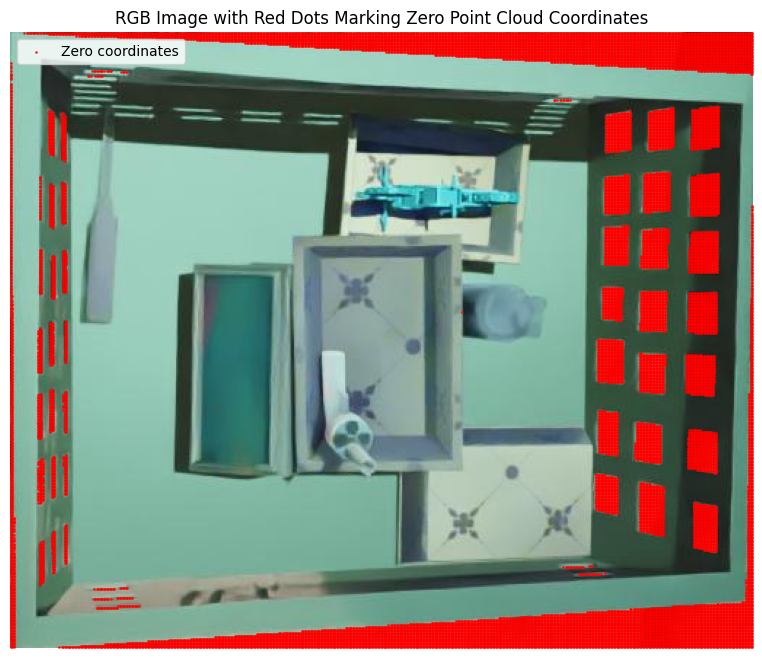

Zero mask shape: (423, 510)
Number of zero pixels: 27944
Percentage of zero pixels: 12.95%


In [34]:
# Create a mask for pixels where all three coordinates are 0
zero_mask = np.all(pc3d == 0, axis=0)  # Shape: (H, W)

# Create a visualization showing the zero pixels
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Show the RGB image as background
ax.imshow(rgb_image)

# Find coordinates where all three coords are 0
zero_y, zero_x = np.where(zero_mask)

# Plot red dots where all coordinates are zero
ax.scatter(zero_x, zero_y, c='red', s=1, alpha=0.7, label='Zero coordinates')

ax.set_title('RGB Image with Red Dots Marking Zero Point Cloud Coordinates')
ax.legend()
ax.axis('off')
plt.show()

print(f"Zero mask shape: {zero_mask.shape}")
print(f"Number of zero pixels: {np.sum(zero_mask)}")
print(f"Percentage of zero pixels: {np.sum(zero_mask) / zero_mask.size * 100:.2f}%")